# Assembling a Feature Engineering Pipeline with Feature-engine and Cross-validation 
## Titanic competition

In [57]:
import kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [2]:
cols = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
    'Embarked', 'Survived'
]

data = pd.read_csv('../titanic/train.csv', usecols=cols)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [3]:
# Cabin: extract numerical and categorical part and delete original variable

data['cabin_num'] = data['Cabin'].str.extract('(\d+)') # captures numerical part
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['Cabin'].str[0] # captures the first letter

data.drop(['Cabin'], axis=1, inplace=True)

In [4]:
# make list of variables types

# numerical: discrete and continuous
discrete = [
    var for var in data.columns if data[var].dtype != 'O' and var != 'Survived'
    and data[var].nunique() < 10
]
continuous = [
    var for var in data.columns
    if data[var].dtype != 'O' and var != 'Survived' and var not in discrete
]

# categorical
categorical = [var for var in data.columns if data[var].dtype == 'O']

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

There are 3 discrete variables
There are 3 continuous variables
There are 3 categorical variables


In [5]:
# separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1),  # predictors
    data['Survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((801, 9), (90, 9))

## Set up Pipeline

In [58]:
titanic_pipe = Pipeline([

    # missing data imputation - section 4
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['Age', 'Fare', 'cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalImputer(variables=['Embarked', 'cabin_cat'])),

    # categorical encoding - section 6
    ('encoder_rare_label',
     ce.RareLabelEncoder(tol=0.01,
                                    n_categories=2,
                                    variables=['Embarked', 'cabin_cat'])),
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                                  variables=['cabin_cat', 'Sex', 'Embarked'])),

    # Gradient Boosted machine
    # ('gbm', GradientBoostingClassifier(random_state=0))
    ('gbm', XGBClassifier(random_state=0))
])

## Set up the Grid ad the cross-validation strategy 

In [59]:
# now we create the grid with all the parameters that we would like to test

param_grid = {
    # try different feature engineering parameters
    'imputer_num__arbitrary_number': [-1, 99],
    'encoder_rare_label__tol': [0.1, 0.2],
    'categorical_encoder__encoding_method': ['ordered', 'arbitrary'],
    
    # try different gradient boosted tree model paramenters
    'gbm__max_depth': [None, 1, 3],
}


# now we set up the grid search with cross-validation
grid_search = GridSearchCV(titanic_pipe, param_grid,
                           cv=5, n_jobs=-1, scoring='roc_auc')

# cv=5 is the cross-validation steps
# no_jobs =-1 indicates to use all available cpus
# scoring='roc-auc' indicates to evaluate the model performance with the roc-auc

# for more details in the grid parameters visit:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [60]:
# and now we train over all the possible combinations of the parameters above
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search: %.3f"
       % grid_search.score(X_train, y_train)))

best roc-auc from grid search: 0.968


In [61]:
# we can print the best estimator parameters like this
grid_search.best_estimator_

Pipeline(steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=99,
                                        variables=['Age', 'Fare',
                                                   'cabin_num'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['Embarked', 'cabin_cat'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=2, tol=0.1,
                                  variables=['Embarked', 'cabin_cat'])),
                ('categorical_encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                v...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

In [62]:
# and find the best fit parameters like this
grid_search.best_params_

{'categorical_encoder__encoding_method': 'arbitrary',
 'encoder_rare_label__tol': 0.1,
 'gbm__max_depth': 3,
 'imputer_num__arbitrary_number': 99}

In [63]:
# here we can see all the combinations evaluated during the gridsearch
grid_search.cv_results_['params']

[{'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': None,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': None,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 1,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 1,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 3,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 3,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.2,
  'gbm_

In [64]:
# and here the scores for each of one of the above combinations
grid_search.cv_results_['mean_test_score']

array([0.86239189, 0.86587485, 0.85091987, 0.8559397 , 0.86174266,
       0.86696466, 0.86518467, 0.86934704, 0.8510689 , 0.85584035,
       0.86303416, 0.87203515, 0.86663433, 0.86921884, 0.85039677,
       0.8549627 , 0.86260545, 0.87360104, 0.86518467, 0.86934704,
       0.8510689 , 0.85584035, 0.86303416, 0.87203515])

In [65]:
# and finally let's check the performance over the test set
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best linear regression from grid search: 0.869


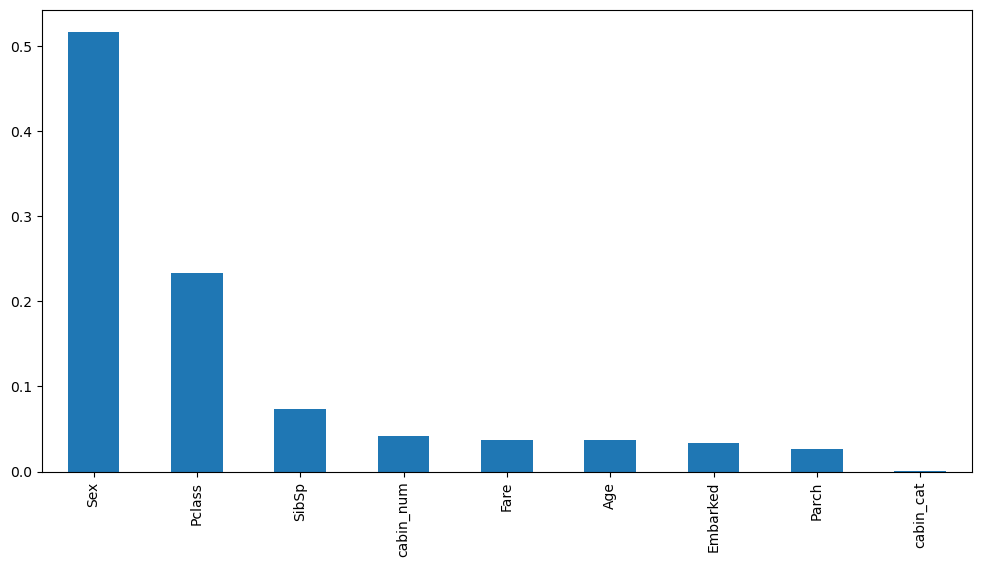

In [66]:
# let's explore the importance of the features

importance = pd.Series(grid_search.best_estimator_['gbm'].feature_importances_)
importance.index = data.drop('Survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6));

## Create submission.csv file

In [67]:
cols = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
    'Embarked'
]

X_test_submission = pd.read_csv('../titanic/test.csv', usecols=cols)

X_test_submission['cabin_num'] = X_test_submission['Cabin'].str.extract('(\d+)') # captures numerical part
X_test_submission['cabin_num'] = X_test_submission['cabin_num'].astype('float')
X_test_submission['cabin_cat'] = X_test_submission['Cabin'].str[0] # captures the first letter

X_test_submission.drop(['Cabin'], axis=1, inplace=True)

X_test_submission.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_num,cabin_cat
0,3,male,34.5,0,0,7.8292,Q,NaN,NaN
1,3,female,47.0,1,0,7.0000,S,NaN,NaN
2,2,male,62.0,0,0,9.6875,Q,NaN,NaN
3,3,male,27.0,0,0,8.6625,S,NaN,NaN
4,3,female,22.0,1,1,12.2875,S,NaN,NaN


In [68]:
submission_file = pd.read_csv('../titanic/test.csv', usecols=['PassengerId'])
submission_file['Survived'] = grid_search.predict(X_test_submission)
submission_file.to_csv('../titanic/submission.csv', index=False)
submission_file.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [69]:
grid_search.best_estimator_['gbm'].feature_importances_

array([2.3297887e-01, 5.1687074e-01, 3.6805920e-02, 7.3368691e-02,
       2.6743675e-02, 3.7569907e-02, 3.3759635e-02, 4.1483130e-02,
       4.1947042e-04], dtype=float32)

In [70]:
grid_search.best_params_

{'categorical_encoder__encoding_method': 'arbitrary',
 'encoder_rare_label__tol': 0.1,
 'gbm__max_depth': 3,
 'imputer_num__arbitrary_number': 99}

In [71]:
# https://www.kaggle.com/competitions/microsoft-malware-prediction/discussion/76245#448176 

# Make a Kaggle submission
kaggle.api.competition_submit(competition='titanic',
                              file_name='../titanic/submission.csv',
                              message=f"classifier = gbm; features = {submission_file.columns}; params = {str(grid_search.best_params_)}")

100%|██████████| 2.77k/2.77k [00:00<00:00, 3.89kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster